Importación de librerías

In [98]:
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
import numpy as np


from IPython.display import display
#Guardar el mejor modelo
from joblib import dump, load
import pickle


from IPython.display import display, Markdown



import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
#pip freeze > requirements.txt

In [100]:
ruta_modelo = './data/Venta/Modelo_Venta_ML.pkl'

Lectura del CSV y primer vistazo

In [101]:
df = pd.read_csv('Anuncio_Venta_ML_Limpio.csv', sep=';')
print(f'El tamaño del dataset es: {df.shape}')
df.head(5)

El tamaño del dataset es: (1596, 11)


,Tipo_vivienda,Superficie construida,Habitaciones,Baños,Planta,Conservación,Precio,PMZona,PMm²Zona,RMP,RMH
0,Piso,125.0,2,2,3.0,En buen estado,540000.0,1028586.40,4151.27,27167.0,86403.0
1,Piso,95.0,3,2,1.0,Reformado,330000.0,404569.14,4016.05,16890.0,41311.0
2,Piso,89.0,2,2,1.0,En buen estado,378000.0,734591.73,3773.82,21254.0,65428.0
3,Piso,95.0,3,2,3.0,En buen estado,339000.0,296686.50,3182.53,13719.0,33790.0
4,Piso,122.0,3,2,1.0,A estrenar,297200.0,260408.74,2079.61,13327.0,39791.0


In [102]:
#Comprobamos que no haya nulos
df.isna().sum()

Tipo_vivienda            0
Superficie construida    0
Habitaciones             0
Baños                    0
Planta                   0
Conservación             0
Precio                   0
PMZona                   0
PMm²Zona                 0
RMP                      0
RMH                      0
dtype: int64

In [103]:
#Para visualizar la muestra que tenemos por precio
for i in range(300000, 9000000, 300000):
    print(f'{i}: {df[df["Precio"]<i].shape}\n')


300000: (701, 11)

600000: (1261, 11)

900000: (1441, 11)

1200000: (1524, 11)

1500000: (1587, 11)

1800000: (1596, 11)

2100000: (1596, 11)

2400000: (1596, 11)

2700000: (1596, 11)

3000000: (1596, 11)

3300000: (1596, 11)

3600000: (1596, 11)

3900000: (1596, 11)

4200000: (1596, 11)

4500000: (1596, 11)

4800000: (1596, 11)

5100000: (1596, 11)

5400000: (1596, 11)

5700000: (1596, 11)

6000000: (1596, 11)

6300000: (1596, 11)

6600000: (1596, 11)

6900000: (1596, 11)

7200000: (1596, 11)

7500000: (1596, 11)

7800000: (1596, 11)

8100000: (1596, 11)

8400000: (1596, 11)

8700000: (1596, 11)



In [104]:
# Lista de rangos que escogeremos para hacer los diferentes modelos
#lista_rangos_precio = list(range(600000, 7000000, 1000000))
lista_rangos_precio = [max(df['Precio'])]
lista_rangos_precio

[1650000.0]

In [105]:
df.dtypes

Tipo_vivienda             object
Superficie construida    float64
Habitaciones               int64
Baños                      int64
Planta                   float64
Conservación              object
Precio                   float64
PMZona                   float64
PMm²Zona                 float64
RMP                      float64
RMH                      float64
dtype: object

In [106]:
df.describe()

,Superficie construida,Habitaciones,Baños,Planta,Precio,PMZona,PMm²Zona,RMP,RMH
count,1596.000000,1596.000000,1596.000000,1596.000000,1.596000e+03,1.596000e+03,1596.000000,1596.000000,1596.000000
mean,132.656642,2.958647,2.018797,1.741228,4.357894e+05,5.663178e+05,3576.656316,16673.845238,44613.736216
std,81.193642,1.126837,0.925242,1.975497,3.097142e+05,4.091813e+05,2028.435082,4680.442397,12177.121957
min,40.000000,1.000000,1.000000,-1.000000,6.770000e+04,7.200000e+04,450.000000,10007.000000,24890.000000
25%,79.000000,2.000000,1.000000,0.000000,2.139848e+05,2.772230e+05,2158.770000,13080.000000,36317.000000
50%,108.500000,3.000000,2.000000,1.000000,3.394500e+05,3.815609e+05,2777.760000,15115.000000,39321.000000
75%,158.000000,3.000000,3.000000,2.000000,5.482000e+05,7.345917e+05,4200.490000,19416.000000,54713.000000
max,887.000000,11.000000,8.000000,13.000000,1.650000e+06,1.616818e+06,9115.300000,28233.000000,86403.000000


## ENCODING

En este cuadro de código podemos probar incluyendo o excluyendo la columna "Conservación" y podemos probar el encoding de la misma y de la columna "Tipo_vivienda"

In [107]:
incluir_conservacion = 1

#EL ERROR DE TODAS LAS COMBINACIONES QUE SE PUEDEN PROBAR (Con conservacion y sin conservación, con onehotencoder o con labelencoder) y las puntuaciones que nos ha dado:

#ESQUEMA:
#    1(Con conservacion) o 0(Sin conservacion) :    [CONSERVACION] 0(LabelEncoder) o 1(OneHotEncoder)    -   [TIPO_VIVIENDA] 0(LabelEncoder) o 1(OneHotEncoder)


# 0: X-0 -- 12k a 114k
# 0: X-1 -- 6k a 118k

# 1: 0-0 -- 14K a 112k
# 1: 1-0 -- 15k a 114k
# 1: 1-1 -- 27k a 114k
# 1: 0-1 -- 11k a 111k

conservacion_onehot = 0
tipovivienda_onehot = 1

# 0  --> Labelencoder
# 1  --> OneHotEncoder

if incluir_conservacion == 1:


    if conservacion_onehot == 0:
        df['Conservación'] = df['Conservación'].replace({'A reformar': 0, 'En buen estado': 1, 'Reformado': 2, 'A estrenar': 3})
        print(df['Conservación'].value_counts())
    elif conservacion_onehot == 1:
        enc = OneHotEncoder()
        onehotdf = pd.DataFrame(enc.fit_transform(df[['Conservación']]).toarray(), columns=enc.get_feature_names_out(['Conservación']), index=df.index)
        df = pd.concat([df, onehotdf], axis=1)
        df.drop(columns=['Conservación'], inplace=True)

    df.dtypes
else:
    df.drop(columns=['Conservación'], inplace=True)
    df.reset_index(drop=True, inplace=True)

1    825
3    472
0    152
2    147
Name: Conservación, dtype: int64


Columna Tipo_vivienda

In [108]:
df['Tipo_vivienda'].value_counts()

Piso                  1143
Casa adosada            93
Ático                   91
Chalet                  84
Dúplex                  52
Casa                    38
Casa unifamiliar        20
Casa pareada            18
Chalet adosado          18
Apartamento             17
Chalet pareado           9
Loft                     7
Estudio                  4
Casa rústica             1
Chalet unifamiliar       1
Name: Tipo_vivienda, dtype: int64

In [109]:



if tipovivienda_onehot == 0:
    enc = LabelEncoder()
    df['Tipo_vivienda'] = enc.fit_transform(df['Tipo_vivienda'])
    print(df['Tipo_vivienda'].value_counts())
elif tipovivienda_onehot == 1:
    enc = OneHotEncoder()
    onehotdf = pd.DataFrame(enc.fit_transform(df[['Tipo_vivienda']]).toarray(), columns=enc.get_feature_names_out(['Tipo_vivienda']), index=df.index)
    df = pd.concat([df, onehotdf], axis=1)
    df.drop(columns=['Tipo_vivienda'], inplace=True)


df.dtypes


Superficie construida               float64
Habitaciones                          int64
Baños                                 int64
Planta                              float64
Conservación                          int64
Precio                              float64
PMZona                              float64
PMm²Zona                            float64
RMP                                 float64
RMH                                 float64
Tipo_vivienda_Apartamento           float64
Tipo_vivienda_Casa                  float64
Tipo_vivienda_Casa adosada          float64
Tipo_vivienda_Casa pareada          float64
Tipo_vivienda_Casa rústica          float64
Tipo_vivienda_Casa unifamiliar      float64
Tipo_vivienda_Chalet                float64
Tipo_vivienda_Chalet adosado        float64
Tipo_vivienda_Chalet pareado        float64
Tipo_vivienda_Chalet unifamiliar    float64
Tipo_vivienda_Dúplex                float64
Tipo_vivienda_Estudio               float64
Tipo_vivienda_Loft              

In [110]:
# Este cuadro de código sirve para eliminar las columnas que no tienen un coeficiente de correlación significativo tras el encoding.
# Sin embargo, probando diferentes combinaciones, dejándo las columnas se obtiene un RMSE más bajo, por lo que se ha decidido dejarlas.

columnas_sin_coeficiente = [
    'Tipo_vivienda_Casa rústica',
    'Tipo_vivienda_Chalet unifamiliar',
    'Tipo_vivienda_Estudio',
    #'Tipo_vivienda_Loft',
    #'Tipo_vivienda_Apartamento',
    #'Tipo_vivienda_Chalet pareado',
    #'Tipo_vivienda_Casa pareada',
    #'Tipo_vivienda_Chalet adosado',
    #'Tipo_vivienda_Casa unifamiliar',
    #'Tipo_vivienda_Casa'
]
df.drop(columns=columnas_sin_coeficiente, inplace=True)

df.dtypes

Superficie construida             float64
Habitaciones                        int64
Baños                               int64
Planta                            float64
Conservación                        int64
Precio                            float64
PMZona                            float64
PMm²Zona                          float64
RMP                               float64
RMH                               float64
Tipo_vivienda_Apartamento         float64
Tipo_vivienda_Casa                float64
Tipo_vivienda_Casa adosada        float64
Tipo_vivienda_Casa pareada        float64
Tipo_vivienda_Casa unifamiliar    float64
Tipo_vivienda_Chalet              float64
Tipo_vivienda_Chalet adosado      float64
Tipo_vivienda_Chalet pareado      float64
Tipo_vivienda_Dúplex              float64
Tipo_vivienda_Loft                float64
Tipo_vivienda_Piso                float64
Tipo_vivienda_Ático               float64
dtype: object

## Selección de columnas y target

In [111]:
target = 'Precio'
column_features = df.columns.to_list()
column_features.remove(target)

column_features

['Superficie construida',
 'Habitaciones',
 'Baños',
 'Planta',
 'Conservación',
 'PMZona',
 'PMm²Zona',
 'RMP',
 'RMH',
 'Tipo_vivienda_Apartamento',
 'Tipo_vivienda_Casa',
 'Tipo_vivienda_Casa adosada',
 'Tipo_vivienda_Casa pareada',
 'Tipo_vivienda_Casa unifamiliar',
 'Tipo_vivienda_Chalet',
 'Tipo_vivienda_Chalet adosado',
 'Tipo_vivienda_Chalet pareado',
 'Tipo_vivienda_Dúplex',
 'Tipo_vivienda_Loft',
 'Tipo_vivienda_Piso',
 'Tipo_vivienda_Ático']

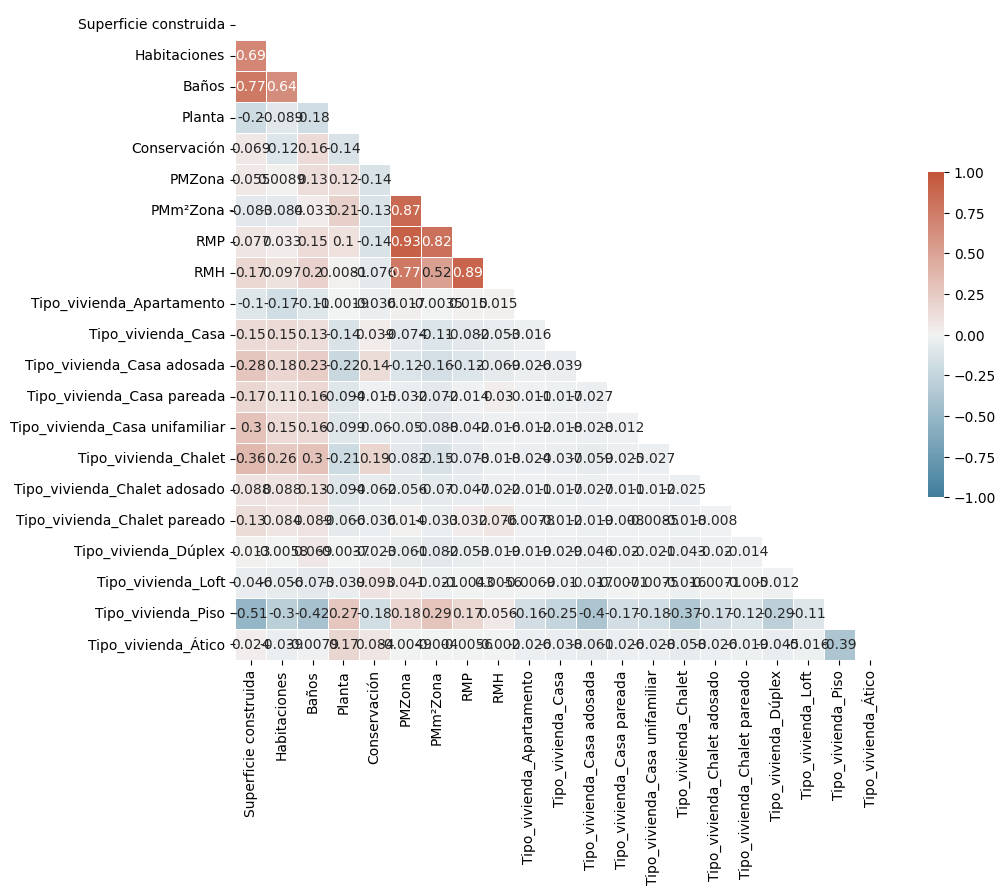

In [112]:
target = 'Precio'


# Generate a large random dataset
# Compute the correlation matrix
corr = df[column_features].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1.0, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.tight_layout()
plt.show()

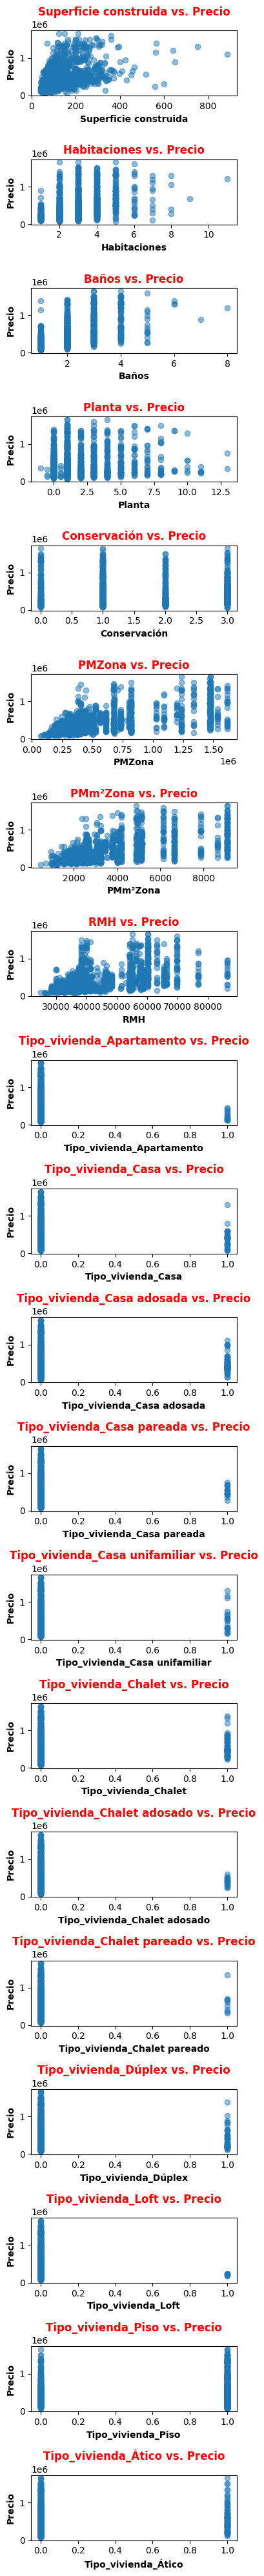

In [113]:
#Eliminamos RMP (Renta Media por Persona) ya que correlaciona con > 0.9 con PMZona y no aporta información
df = df.drop(columns=['RMP'], inplace=False)
column_features.remove('RMP')
df.reset_index(drop=True, inplace=True)


# Set up subplots
num_plots = len(column_features)
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(4, 2 * num_plots))

# Iterate through feature columns and create scatter plots
for i, feature in enumerate(column_features):
    axes[i].scatter(df[feature], df['Precio'], alpha=0.5)
    axes[i].set_title(f'{feature} vs. Precio', fontweight='bold', c='r')
    axes[i].set_xlabel(feature, fontweight='bold')
    axes[i].set_ylabel('Precio', fontweight='bold')

plt.tight_layout()
plt.show()

Correlaciones entre Precio-Features

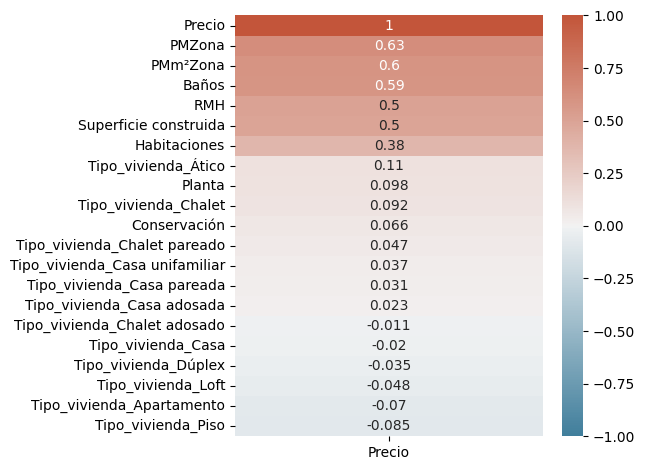

In [114]:
total_columns=column_features

total_columns.append(target)

df_correlation_target = df[total_columns].corr().sort_values(by='Precio', ascending=False)[['Precio']]

sns.heatmap(df_correlation_target, cmap=cmap, vmin=-1, vmax=1, annot=True)

plt.tight_layout()

In [115]:
df.columns

Index(['Superficie construida', 'Habitaciones', 'Baños', 'Planta',
       'Conservación', 'Precio', 'PMZona', 'PMm²Zona', 'RMH',
       'Tipo_vivienda_Apartamento', 'Tipo_vivienda_Casa',
       'Tipo_vivienda_Casa adosada', 'Tipo_vivienda_Casa pareada',
       'Tipo_vivienda_Casa unifamiliar', 'Tipo_vivienda_Chalet',
       'Tipo_vivienda_Chalet adosado', 'Tipo_vivienda_Chalet pareado',
       'Tipo_vivienda_Dúplex', 'Tipo_vivienda_Loft', 'Tipo_vivienda_Piso',
       'Tipo_vivienda_Ático'],
      dtype='object')

In [116]:
df.dtypes

Superficie construida             float64
Habitaciones                        int64
Baños                               int64
Planta                            float64
Conservación                        int64
Precio                            float64
PMZona                            float64
PMm²Zona                          float64
RMH                               float64
Tipo_vivienda_Apartamento         float64
Tipo_vivienda_Casa                float64
Tipo_vivienda_Casa adosada        float64
Tipo_vivienda_Casa pareada        float64
Tipo_vivienda_Casa unifamiliar    float64
Tipo_vivienda_Chalet              float64
Tipo_vivienda_Chalet adosado      float64
Tipo_vivienda_Chalet pareado      float64
Tipo_vivienda_Dúplex              float64
Tipo_vivienda_Loft                float64
Tipo_vivienda_Piso                float64
Tipo_vivienda_Ático               float64
dtype: object

## APLICACIÓN DE MODELOS:

In [117]:
tipomodelo = (
    make_pipeline,
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    KNeighborsRegressor,
    Lasso,
    Ridge,
    LinearRegression,
    ExtraTreesRegressor
)

stringmodelo = [
    'Polinomyal',
    'RandomForestRegressor',
    'GradientBoostingRegressor',
    'KNeighborsRegressor',
    'Lasso',
    'Ridge',
    'LinearRegression',
    'ExtraTreesRegressor'
]

In [118]:
param_grid = [
        {   #(make_pipeline) Polynomial  --> (PolynomialFeatures(),StandardScaler(),LinearRegression()) #PABLO: BAJAR GRADO
            'polynomialfeatures__degree': [1, 2, 3],  # Degrees of polynomial features
            #'linearregression__normalize': [True, False]  # Whether to normalize the features
        },
        {   #RandomForestRegressor #PABLO: BAJAR PROFUNDIDAD
            'bootstrap': [False, True], 
            'n_estimators': [3, 10, 30, 50, 100], 
            'max_features': [2, 4, 6, 8],
            'max_depth': [None, 3, 5, 7, 10],
            'random_state': [42]
        },
        {   #GradientBoostingRegressor
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4],
            'random_state': [42]
        },
        {   #KNeighborsRegressor #PABLO: BAJAR LA K
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]  # 1 para la distancia de Manhattan, 2 para la distancia euclidiana
        },
        {   #Lasso
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],  # Regularization strength
            'random_state': [42]
        },
        {   #Ridge
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],  # Regularization strength
            'random_state': [42]
        },
        {   #LinearRegression
            
        },
        {   #ExtraTreesRegressor
            'n_estimators': [50, 100, 150],  # Number of trees in the forest
            'max_depth': [None, 10, 20, 25],  # Maximum depth of the tree
            'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
            'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
            'random_state': [42]            
        }
]

In [119]:

df_metricas = []
mejor_modelo = ExtraTreesRegressor()
n_mejor = 0


for rangoprecio in lista_rangos_precio:
    df_filtrado = df[df['Precio']<=rangoprecio]
    X = df_filtrado[column_features].drop(columns=['Precio'])
    y = df_filtrado[target]

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    rmse_lista = []
    best_model = []
    best_dataframe = []

    for i in range(len(param_grid)):
        if i==0:
            modelo = tipomodelo[i](PolynomialFeatures(),StandardScaler(), LinearRegression())
        else:
            modelo = tipomodelo[i]()

        # Perform Grid Search Cross-Validation
        grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid[i], cv=5, scoring='neg_root_mean_squared_error')

        grid_search.fit(X_train, y_train)

        # Realizar predicciones en el conjunto de prueba
        best_model.append(grid_search.best_estimator_)

        # PREDECIMOS EL TRAIN Y EL TEST
        y_pred = best_model[i].predict(X_train)
        y_pred_test = best_model[i].predict(X_test)


        train_mae = round(mean_absolute_error(y_train, y_pred), 2)
        test_mae = round(mean_absolute_error(y_test, y_pred_test), 2)

        train_mse = round(mean_squared_error(y_train, y_pred), 2)
        test_mse = round(mean_squared_error(y_test, y_pred_test), 2)

        train_rmse = round(np.sqrt(mean_squared_error(y_train, y_pred)), 2)
        test_rmse = round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 2)

        train_r2score = round(r2_score(y_train, y_pred), 2)
        test_r2score = round(r2_score(y_test, y_pred_test), 2)

        train_mape = round((mean_absolute_percentage_error(y_train, y_pred)*100), 2)
        test_mape = round((mean_absolute_percentage_error(y_test, y_pred_test)*100), 2)


        data = {
            'TRAIN' : [train_mae, train_mse, train_rmse, train_r2score, train_mape],
            stringmodelo[i] : [test_mae, test_mse, test_rmse, test_r2score, test_mape]
        }


        rmse_lista.append(test_rmse)

        dataframe = pd.DataFrame(data, index=['MAE', 'MSE', 'RMSE', 'R2Score', 'MAPE'])
        dataframe['Difference'] = dataframe[stringmodelo[i]]-dataframe['TRAIN']
        best_dataframe.append(dataframe.T)



    for n in range(len(rmse_lista)):

        if rmse_lista[n] == min(rmse_lista):

            df_metricas.append(best_dataframe[n])
            mejor_modelo =best_model[n]
            print(f'El mejor modelo para el rango <= {rangoprecio} es {best_model[n]}\nRMSE: {rmse_lista[n]}\n')
            display(best_dataframe[n])
            pickle.dump(best_model[n], open(f"{ruta_modelo}", "wb"))

            break


C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.281e+13, tolerance: 1.042e+10
  model = cd_fast.enet_coordinate_descent(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.280e+13, tolerance: 9.828e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

El mejor modelo para el rango <= 1650000.0 es ExtraTreesRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                    n_estimators=150, random_state=42)
RMSE: 108853.44



,MAE,MSE,RMSE,R2Score,MAPE
TRAIN,32875.14,3.601072e+09,60008.93,0.96,7.54
ExtraTreesRegressor,63553.85,1.184907e+10,108853.44,0.87,16.44
Difference,30678.71,8.247999e+09,48844.51,-0.09,8.90


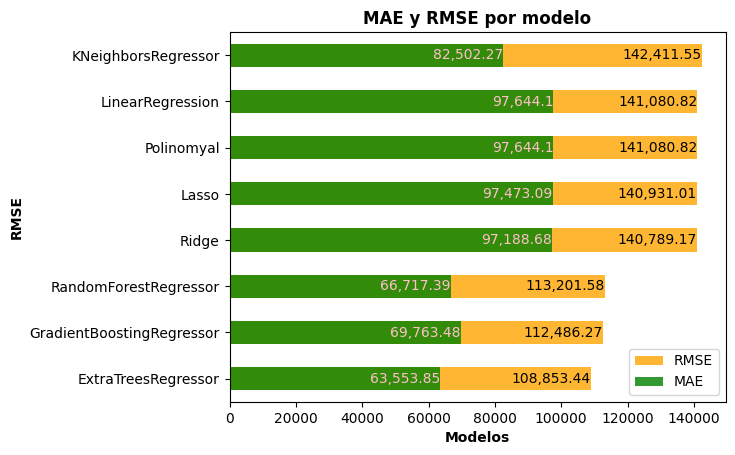

In [120]:
mydataerrors = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'R2Score', 'MAPE'])
for h in range(len(stringmodelo)):
    row =  pd.DataFrame(best_dataframe[h].iloc[1]).T
    mydataerrors = pd.concat([mydataerrors, row], axis=0)




mydataerrors.drop(columns=['MSE'], inplace=True)
mydataerrors.sort_values(by='RMSE', inplace=True)
mydataerrors['RMSE'].plot.barh(color='orange', alpha=0.8)
mydataerrors['MAE'].plot.barh(color='green', alpha=0.8)

plt.title('MAE y RMSE por modelo', fontweight='bold')
plt.xlabel('Modelos', fontweight='bold')
plt.ylabel('RMSE', fontweight='bold')

# Annotating the bars with values from df1
for index, value in enumerate(mydataerrors['RMSE']):
    plt.text(value, index, format(value, ','), ha='right', va='center', color='black')

# Annotating the bars with values from df2
for index, value in enumerate(mydataerrors['MAE']):
    plt.text(value, index, format(value, ','), ha='right', va='center', color='pink')

plt.legend()

plt.show()


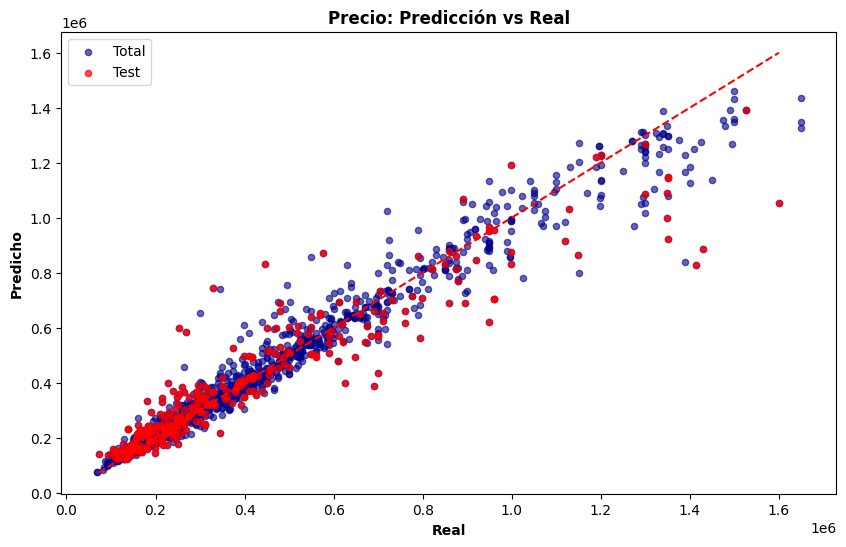

In [121]:
# Visualización del acierto del modelo

X_total = df[column_features].drop(columns=['Precio'])
y_total = df[target]

y_predicha = mejor_modelo.predict(X_total)

mydataframe = pd.DataFrame({'Real': y_total, 'Predicho': y_predicha})
mydataframe = mydataframe.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 6))

mydataframe.plot(x='Real', y='Predicho', kind='scatter', alpha=0.6, color='darkblue', ax=ax)

y_test_predicho = mejor_modelo.predict(X_test)
my_test_dataframe = pd.DataFrame({'Real': y_test, 'Predicho': y_test_predicho})

my_test_dataframe.plot(x='Real', y='Predicho', kind='scatter', alpha=0.7, color='red', ax=ax)


plt.title('Precio: Predicción vs Real', fontweight='bold')

plt.xlabel('Real', fontweight='bold')
plt.ylabel('Predicho', fontweight='bold')


# Trazar la línea diagonal
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g--')

plt.legend(['Total', 'Test'])
# Mostrar el gráfico
plt.show()



Modelo: ExtraTreesRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                    n_estimators=150, random_state=42) y [1650000.0]
Para el rango 101550 el RMSE es: 16192.3 --> 15.95%
Para el rango 251550 el RMSE es: 32979.62 --> 13.11%
Para el rango 401550 el RMSE es: 60304.56 --> 15.02%
Para el rango 551550 el RMSE es: 47150.78 --> 8.55%
Para el rango 701550 el RMSE es: 59110.17 --> 8.43%
Para el rango 851550 el RMSE es: 48595.53 --> 5.71%
Para el rango 1001550 el RMSE es: 62587.79 --> 6.25%
Para el rango 1151550 el RMSE es: 47476.73 --> 4.12%
Para el rango 1301550 el RMSE es: 60245.08 --> 4.63%
Para el rango 1451550 el RMSE es: 67412.33 --> 4.64%
Para el rango 1601550 el RMSE es: 86845.17 --> 5.42%
Para el rango 1751550 el RMSE es: 108853.44 --> 6.21%
Para el rango 1901550 el RMSE es: 108853.44 --> 5.72%


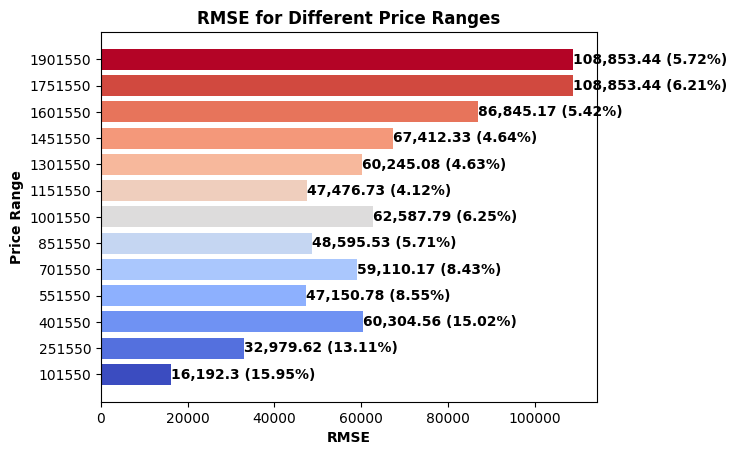

In [122]:

#Para probar el RMSE seleccionando cada modelo y en función del rango de precios

print(f'Modelo: {mejor_modelo} y {lista_rangos_precio}')

paraplot = {}
num = []
lista_precios_pruebarmse = list(range(int(min(df['Precio'])*1.5), int(max(df['Precio'])*1.2), 150000))
for j in lista_precios_pruebarmse:
    dftry = df[df['Precio']<=j]
    X = dftry[column_features].drop(columns=['Precio'])
    y = dftry[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_pred = mejor_modelo.predict(X_train)
    y_pred_test = mejor_modelo.predict(X_test)
    train_rmse = round(np.sqrt(mean_squared_error(y_train, y_pred)), 2)
    test_rmse = round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 2)
    perc = round((test_rmse*100)/j, 2)
    num.append(perc)
    print(f'Para el rango {j} el RMSE es: {test_rmse} --> {perc}%')
    paraplot[j] = test_rmse


import matplotlib.pyplot as plt
# Create a colormap for the color gradient
cmap = plt.cm.get_cmap('coolwarm')

# Sort the paraplot dictionary by keys
paraplot_sorted = dict(sorted(paraplot.items()))

# Get the values and keys from the sorted dictionary
values = list(paraplot_sorted.values())
keys = list(paraplot_sorted.keys())

# Create a color array for the bars based on the values
colors = cmap(np.linspace(0, 1, len(values)))

# Plot the horizontal bar chart
plt.barh(range(len(values)), values, align='center', color=colors)

# Set the y-axis ticks and labels
plt.yticks(range(len(values)), keys)

# Set the x-axis label
plt.xlabel('RMSE', fontweight='bold')

# Set the y-axis label
plt.ylabel('Price Range', fontweight='bold')

# Set the title
plt.title('RMSE for Different Price Ranges', fontweight='bold')

# Add text annotations to the bars
for i, value in enumerate(values):
    plt.text(value, i, format(round(float(value), 2), ',')+' ('+format(round(float(num[i]), 2), ',')+'%)', ha='left', va='center', fontweight='bold', c='k')

# Show the plot
plt.show()



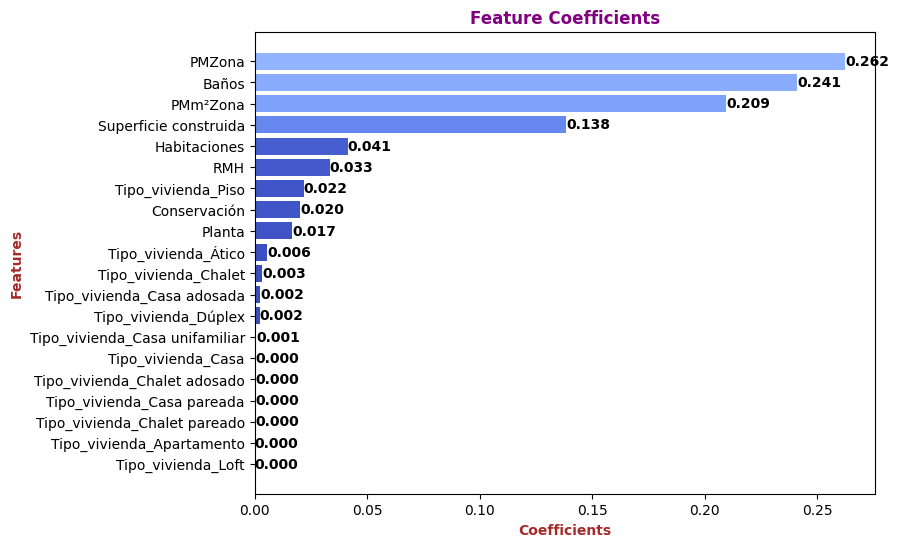

In [123]:
coeficientes = mejor_modelo.feature_importances_
evalue_features = X.columns.to_list()


# Zip the two arrays together
zipped = zip(evalue_features, coeficientes)

# Sort the zipped list by values
sorted_zipped = sorted(zipped, key=lambda x: x[1])

# Unzip the sorted zipped list
sorted_features, sorted_coefficients = zip(*sorted_zipped)

# Plot the coefficients
plt.figure(figsize=(8, 6))  # Increase the figure size

# Create a colormap for the color gradient
cmap = plt.cm.get_cmap('coolwarm')

# Plot the horizontal bar chart with color gradient
plt.barh(sorted_features, sorted_coefficients, color=cmap(sorted_coefficients))

# Add labels to the bars
for i, (feature, coefficient) in enumerate(zip(sorted_features, sorted_coefficients)):
    plt.text(coefficient, i, f'{coefficient:.3f}', ha='left', va='center', fontweight='bold', c='k')

# Set the x-axis label
plt.xlabel('Coefficients', fontweight='bold', c='brown')

# Set the y-axis label
plt.ylabel('Features', fontweight='bold', c='brown')

# Set the title
plt.title('Feature Coefficients', fontweight='bold', c='purple')


plt.show()


In [124]:
df_importancia = pd.DataFrame({'Feature': evalue_features, 'Importance': coeficientes})
df_importancia.sort_values(by='Importance', ascending=True, inplace=True)
df_importancia[df_importancia['Importance']<=10]

,Feature,Importance
17,Tipo_vivienda_Loft,0.000023
8,Tipo_vivienda_Apartamento,0.000058
15,Tipo_vivienda_Chalet pareado,0.000191
11,Tipo_vivienda_Casa pareada,0.000245
14,Tipo_vivienda_Chalet adosado,0.000282
9,Tipo_vivienda_Casa,0.000398
12,Tipo_vivienda_Casa unifamiliar,0.000632
16,Tipo_vivienda_Dúplex,0.002314
10,Tipo_vivienda_Casa adosada,0.002344
13,Tipo_vivienda_Chalet,0.003297


# Input de modelo

In [125]:
X_train.dtypes

Superficie construida             float64
Habitaciones                        int64
Baños                               int64
Planta                            float64
Conservación                        int64
PMZona                            float64
PMm²Zona                          float64
RMH                               float64
Tipo_vivienda_Apartamento         float64
Tipo_vivienda_Casa                float64
Tipo_vivienda_Casa adosada        float64
Tipo_vivienda_Casa pareada        float64
Tipo_vivienda_Casa unifamiliar    float64
Tipo_vivienda_Chalet              float64
Tipo_vivienda_Chalet adosado      float64
Tipo_vivienda_Chalet pareado      float64
Tipo_vivienda_Dúplex              float64
Tipo_vivienda_Loft                float64
Tipo_vivienda_Piso                float64
Tipo_vivienda_Ático               float64
dtype: object

In [127]:
X_prueba = pd.DataFrame({
    'Superficie construida': [94],
    'Habitaciones': [3],
    'Baños': [2],
    'Planta': [1],
    'Conservación': [2],
    'PMZona': [274876.67],
    'PMm²Zona': [3074.19],
    'RMH': [38421.0],
    #'Conservación_A estrenar': [0],
    #'Conservación_A reformar': [0],
    #'Conservación_En buen estado': [1],
    #'Conservación_Reformado': [0],
    'Tipo_vivienda_Apartamento': [0],
    'Tipo_vivienda_Casa': [0],
    'Tipo_vivienda_Casa adosada': [0],
    'Tipo_vivienda_Casa pareada': [0],
    #'Tipo_vivienda_Casa rústica' : [0],
    'Tipo_vivienda_Casa unifamiliar': [0],
    'Tipo_vivienda_Chalet': [0],
    'Tipo_vivienda_Chalet adosado': [0],
    'Tipo_vivienda_Chalet pareado': [0],
    #'Tipo_vivienda_Chalet unifamiliar': [0],
    'Tipo_vivienda_Dúplex': [0],
    #'Tipo_vivienda_Estudio': [0],
    'Tipo_vivienda_Loft': [0],
    'Tipo_vivienda_Piso': [1],
    'Tipo_vivienda_Ático': [0]

})


predecimos = mejor_modelo.predict(X_prueba)

display(Markdown("# Tu piso se estima en %.2f €" % (predecimos[0])))

# Tu piso se estima en 310392.10 €

In [128]:
otrodf = pd.read_csv('Anuncios_venta_dataset_final.csv', sep=';')
# Assuming you have a dataframe named 'df' asd
resta = format(round(predecimos[0]-otrodf.iloc[1092][15], 2), ',')
display(Markdown(   f'# {otrodf.iloc[1092][15]}\n\n# RESTA: {resta}'   )  )


# 295000.0

# RESTA: 15,392.1

In [129]:
otrodf.iloc[1092]

Referencia                                                    TC717-560876
Tipo_vivienda                                                         Piso
Dirección                                                       Marroquina
Barrio                                                         Marroquina 
Distrito                                                         Moratalaz
Población                                                   Madrid Capital
Superficie construida                                                 94.0
Superficie útil                                                        NaN
Superficie solar                                                       0.0
Habitaciones                                                             3
Baños                                                                    2
Planta                                                                 NaN
Antigüedad                                                             NaN
Conservación             